#################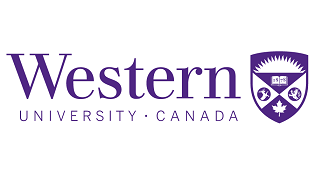###############



###############################################################
###################..........Vahid Ashkanichenarlogh______#################
###################..........Student Num:251260738______#################
###################..........Londan, ON, Canada___________#################
###############################################################


# ***Some useful links that helped me through this research.***


*   https://github.com/shenyichen105/Deep-Reinforcement-Learning-in-Stock-Trading
*   https://github.com/ucaiado/QLearning_Trading
*   https://github.com/Albert-Z-Guo/Deep-Reinforcement-Stock-Trading
*   https://github.com/ThirstyScholar/trading-bitcoin-with-reinforcement-learning
*   https://github.com/AI4Finance-Foundation/FinRL-Meta
*   https://github.com/Kostis-S-Z/trading-rl
*   https://github.com/Rahul-Choudhary-3614/Deep-Reinforcement-Learning-Notebooks
*   https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl









# **Connect to the Google-Drive to access to the data and required storage**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#############################################################
#############################################################
#      Vital point: I put it here to be sure about it. Thanks Prof.

#      Please in order to use the dataset, Save the 
#      training model, and load the trained model 
#      for test phase, change these address by your
#      own google drive address. read the attached csv
#      file of your google drive for csv_address (below).
#      Also create new folders in your google drive, then 
#      change the "models_folder" and "rewards_folder" for
#      these folders. 
#############################################################
#############################################################
#Please note that in order to simplifying the problem we have a dataset to  use "close price" in the csv format.
#Rows in our data correspond for separate day, and columns are for different stocks.
csv_address = '/content/drive/MyDrive/FinalProjectRL/aapl_msi_sbux.csv'
models_folder = '/content/drive/MyDrive/FinalProjectRL/rl_trader_models'
rewards_folder = '/content/drive/MyDrive/FinalProjectRL/rl_trader_rewards'


# **Import the required libraries and load the data**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, CuDNNLSTM,LSTM
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


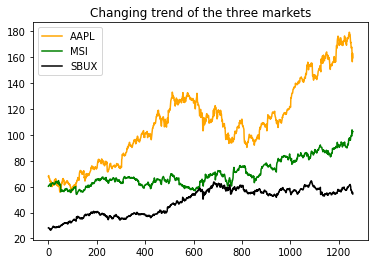

In [ ]:
#############################################################
#############################################################
#  Let's use AAPL (Apple), MSI (Motorola), SBUX (Starbucks)
#  returns a T x 3 list of stock prices
#  each row is a different stock
#  0 = AAPL
#  1 = MSI
#  2 = SBUX
#############################################################
#############################################################
get_data1 = pd.read_csv(csv_address)
get_data=get_data1.values
plt.plot(get_data[:,0], color='orange')
plt.plot(get_data[:,1], color='green')
plt.plot(get_data[:,2], color='black')
plt.title("Changing trend of the three markets")
plt.legend(['AAPL', 'MSI', 'SBUX'])
plt.show()

In [ ]:
### The experience replay memory ###
class ReplayBuffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def sample_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])

# **Normalization step by Scaler**

In [ ]:
################################################################################
################################################################################
#########  this function is to normalizing the states. the idea is that ########
#########  to get the right parameters of our scaler, we must have some ########
#########  data. In order to get this data, I am running a random episode#######
#########  to see which state encounter. there is no need to have an agent.#####
#########  So, you can see that to perform an action we just need a sample######
#########  of action space When we are done, Standard Scaler is fitted to ######
#########                  the state we encountered.                  ##########
################################################################################
################################################################################
def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info, _trade = env.step(action)
    states.append(state)
    if done:
      break
  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

# To create a new directory if it doesn't exists before, to save our model
# and weights. I will use this function later.
def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)


# **MLP: Multi-Layer Perceptron Model definition**

In [ ]:
###############################################################
#0#############################################################
#                                                             #
#             """ A multi-layer perceptron """                #
#     In this part I defined a model by MLP to play as        #
#     an agent with one hidden layer. the number of of        #
#     outputs is the number of action we have(I talked        #
#     about the actions and the number of actions at          #
#     next cells.) Our loss function is Mean Square Error     #
#     and Adam is used as our optimizer. Please note that     #
#     we can change our hyper-parameters (Number of hidden,   #
#     loss-function, and our optimizer) to tuning our model   #
#                      in other ways.                         #
#                                                             #
#     ****I am even going to use LSTM in this work****        #
#     ****and compare the results for both models ****        #
#     ****to prepare it at-least for a conference paper.      #
###############################################################
###############################################################
def mlp(input_dim, n_action, n_hidden_layers=1, hidden_dim=32):
  # input layer
  i = Input(shape=(input_dim,))
  x = i
  # hidden layers
  for _ in range(n_hidden_layers):
    x = Dense(hidden_dim, activation='relu')(x)
  # final layer
  x = Dense(n_action)(x)
  # make the model
  model = Model(i, x)
  model.compile(loss='mse', optimizer='adam')
  print((model.summary()))
  return model


'''def LSTM(input_dim, nb_actions, nb_cell_1,nb_cell_2, nb_unit):
  input_dim = Input(shape=(input_dim,))
  model = Sequential()
  model.add(LSTM(nb_cell_1, input_shape=input_dim))
  model.add(Dense(nb_unit))
  model.add(Activation('relu'))
  x = model.add(Dense(nb_actions, activation='linear'))
  model = Model(input_dim, x)
  model.compile(loss='mse', optimizer='adam')
  print((model.summary()))
  return model'''


"def LSTM(input_dim, nb_actions, nb_cell_1,nb_cell_2, nb_unit):\n  input_dim = Input(shape=(input_dim,))\n  model = Sequential()\n  model.add(LSTM(nb_cell_1, input_shape=input_dim))\n  model.add(Dense(nb_unit))\n  model.add(Activation('relu'))\n  x = model.add(Dense(nb_actions, activation='linear'))\n  model = Model(input_dim, x)\n  model.compile(loss='mse', optimizer='adam')\n  print((model.summary()))\n  return model"

# **Multi-stock Environment definition**

In [ ]:
################################################################################
################################################################################
#             Here I am going to define the environment class.                 #
############       A 3-stock trading environment.             ##################
############       State: vector of size 7 (n_stock * 2 + 1)  ##################
############       shares of stock 1 owned                    ##################
############       shares of stock 2 owned                    ##################
############       shares of stock 3 owned                    ##################
############       price of stock 1 (using daily close price) ##################
############       price of stock 2                           ##################
############       price of stock 3                           ##################
############       cash owned (can be used to purchase more stocks) ############                         
############       Action: categorical variable with 27 (3^3) possibilities ####
############       for each stock, you can:                   ##################
############       0 = sell                                   ##################
############       1 = hold                                   ##################
############       2 = buy                                    ##################
################################################################################
################################################################################
  
class MultiStockEnv:
  #please note that the initial_investment is $20000 as cash. we used it later.
  def __init__(self, data, initial_investment=20000):
    # data
    # set our input data to an attribute
    self.stock_price_history = data
    #here we are defined 2 attributes "n_step or days & n_stock", that I get from our data shape
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None
    # The action space is 27. because we have 3 actions to do (sell, buy, hold), and 3 stocks.
    self.action_space = np.arange(3**self.n_stock)

    # action permutations
    # returns a nested list with elements like:
    # [0,0,0] #it means sell all stocks
    # [0,0,1] #it means sell AAPL and MIS stocks but do nothing (Hold action) for third stock.
    # [0,0,2] #it means sell two first stocks and buy SBUX in third stock.
    # [0,1,0] #it means sell first and third stocks but hold the second (MSI) stock.
    # [0,1,1] 
    # etc.
    # 0 = sell
    # 1 = hold
    # 2 = buy
    #by below code we put actions by [0,1,2] format in a list.
    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1
    #it cause to return to initialized state.
    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    #it says the stock price in current day.
    self.stock_price = self.stock_price_history[self.cur_step]
    # the amount of cash the we have
    self.cash_in_hand = self.initial_investment
    #we return the state vector which is done by a function that we will see the inside
    # of this function shortly.
    return self._get_obs()


  # This function perform an action in the environment and return reward and next-state, and some other things.
  def step(self, action):
    # first we checked in that action we passed in, exist in our action space.
    assert action in self.action_space
    # get current value of our portfolio before performing the action
    prev_val = self._get_val()

    # update price, i.e. go to the next day (cur_step is as day),(stock_pricegoes to next day)
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # perform the trade
    _trade = self._trade(action)

    # get the new value after taking the action
    cur_val = self._get_val()

    # Here I am computing the reward which achieved by current portfolio value - previouse portfoio value
    #reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # the info flag store the current value of the portfolio 
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info, _trade


################################################################################
################################################################################
#                 This description is for _get_obs function.                   #   
#                 get_obs means getting the next state.                        #
#                 this function return the state.                              #
#        sometimes like now, we like to use term state in observation          #
#        interchangeably. there are some case, such as some transformation     #
#        observation. or even be multiple past observations stacked up         #
#        together. as mentioned earlier, this function is going              #
#        to have three components. The fisrt component is the number           #
#        of shares in each stock owned. this should be a list of three.        #
#        The second component is the value of a stock. this also should        #
#        be a list of 3. Finally I added chash money to the last index         #
#                   in our list, and then returned the observation.            #
################################################################################
################################################################################
  def _get_obs(self):
    obs = np.empty(self.state_dim)
    #first component
    obs[:self.n_stock] = self.stock_owned
    #second component. 
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    #third component
    obs[-1] = self.cash_in_hand
    return obs
  

################################################################################
################################################################################
#        This description is for _get_val function.                            #
#        this function return the current value of our portfolio.              #
#        Let see how will I calculated the value of the portfolio?             #
#        Lets consider we have 10 shares of AAPL, 5 shares of MSI,             #
#        and 3 shares of SBUX. If share prices be $50 for AAPL, $20            #
#        for MSI, and $30 for SBUX, and we will have $100 cash, then:          #
#                 Value = 10*50+5*20+3*30+100 = $790                           #
################################################################################
################################################################################                           
  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    # index the action we want to perform
    # 0 = sell
    # 1 = hold
    # 2 = buy
    # e.g. [2,1,0] means:
    # buy first stock
    # hold second stock
    # sell third stock
    action_vector = []
    action_vec = self.action_list[action]
    action_vector.append(action_vec)
    #print(action_vec)
    # determine which stocks to buy or sell
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)
    #This part is considered to simplifying the problem.
    # sell any stocks we want to sell
    # then buy any stocks we want to buy
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
      # NOTE: when buying, we will loop through each stock we want to buy,
      # and buy one share at a time until we run out of cash
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False
    return action_vector

# **Define agent properties, load and save functions for model**

In [ ]:
################################################################################
################################################################################
#             In this part I am going to describe the agent.                   #
#       The agent is AI, that must learn to maximize the feature rewards.      # 
################################################################################
################################################################################       
class DQNAgent(object):
  ############################################################################
  #          first we have constructor. that correspond to                   #
  #          state size and action size. these are correspond                #
  #          to the number of input and output of our neural network.        #
  #          Next we have some hyper-parameters that you can see.            #
  ############################################################################
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = ReplayBuffer(state_size, action_size, size=500)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = mlp(state_size, action_size)

  def update_replay_memory(self, state, action, reward, next_state, done):
    self.memory.store(state, action, reward, next_state, done)

  #this function takes a state and uses epsilon greedy to choose an action based on that state
  def act(self, state):
    #first we generate a random number between 0 and 1, and check the list of epsilon.
    #if it is, then we perform a random action. Otherwise, we perform a greedy action
    #by grabing the all Q-values for the input state. Then the action is that has maximum value.
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = self.model.predict(state)
    # the output of our model is batchsize by the number of outputs. so, I index the return value
    # by 0, before taking the argmax.
    return np.argmax(act_values[0])  # returns action



  def replay(self, batch_size=32):
    # first check if replay buffer contains enough data
    if self.memory.size < batch_size:
      return

    # sample a batch of data from the replay memory
    minibatch = self.memory.sample_batch(batch_size)
    states = minibatch['s']
    actions = minibatch['a']
    rewards = minibatch['r']
    next_states = minibatch['s2']
    done = minibatch['d']

    # Calculate the tentative target: Q(s',a)
    target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)

    ###########################################################################
    ###########################################################################
    #        With the Keras API, the target (usually) must have the same      #
    #        shape as the predictions. However, we only need to update        #
    #        the network for the actions which were actually taken.           #
    #        We can accomplish this by setting the target to be equal to      #
    #        the prediction for all values. Then, only change the targets     #
    #        for the actions taken. Q(s,a).                                   #
    ###########################################################################
    ###########################################################################
    target_full = self.model.predict(states)
    target_full[np.arange(batch_size), actions] = target

    # Run one training step
    self.model.train_on_batch(states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay

  #function for load the saved model
  def load(self, name):
    self.model.load_weights(name)
  #function to save the model
  def save(self, name):
    self.model.save_weights(name)


# **Play the agent for one episode**

In [ ]:
def play_one_episode(agent, env, is_train):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False
  trade_in_each_action = []
  #num_episodes = 0
  while not done:
    #num_episodes+=1
    action = agent.act(state)
    #actions.append(action)
    next_state, reward, done, info, _trade = env.step(action)
    #if num_episodes==4:
    trade_in_each_action.append(_trade)
    #rewards.append(reward)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val'], action, reward, _trade, trade_in_each_action

# **Adjusting some parameters as well as plotting the data distribution**


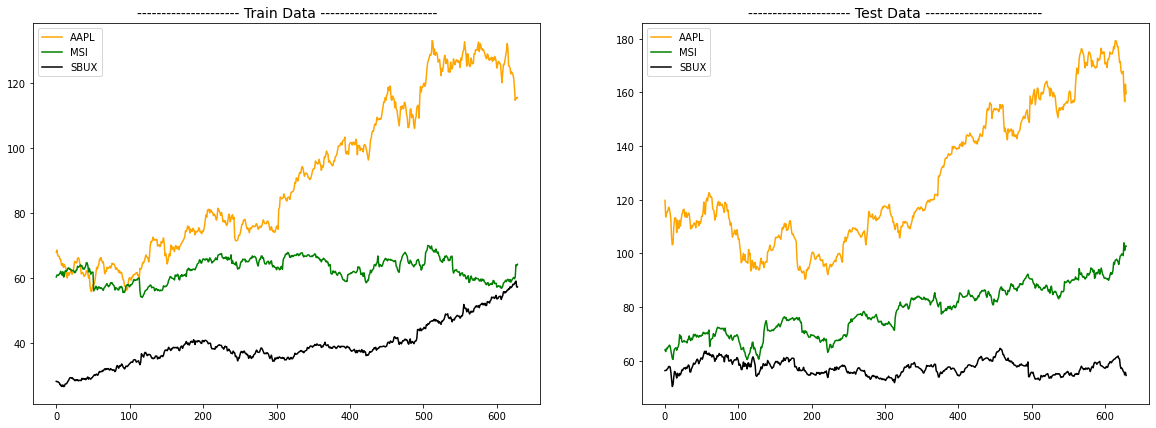

In [ ]:
# Here I have defined some parameters 
num_episodes = 500
batch_size = 32
initial_investment = 20000
#check for directory. it is exists or not.
maybe_make_dir(models_folder)  
maybe_make_dir(rewards_folder)
#get data and declared to n_timesteps, n_stocks
data = get_data
n_timesteps, n_stocks = data.shape

n_train = n_timesteps // 2
#split train and test data
train_data = data[:n_train]
test_data = data[n_train:]
#By all below codes, I showed the distribution of each stocks in train and test sets. 
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (20, 7))
ax1.plot(train_data[:,0], color="orange")
ax1.plot(train_data[:,1], color="green")
ax1.plot(train_data[:,2], color="black")
ax1.set_title("--------------------- Train Data ------------------------", fontsize = 14)
ax1.legend(['AAPL', 'MSI', 'SBUX'])

ax2.plot(test_data[:,0], color="orange")
ax2.plot(test_data[:,1], color="green")
ax2.plot(test_data[:,2], color="black")
ax2.set_title("--------------------- Test Data ------------------------", fontsize = 14)
ax2.legend(['AAPL', 'MSI', 'SBUX'])


# **Training the model (agent)**

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_6 (Dense)             (None, 32)                256       
                                                                 
 dense_7 (Dense)             (None, 27)                891       
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
None
episode: 1/500, episode_end_value: 32345.15, duration: 0:00:54.801606
episode: 2/500, episode_end_value: 24884.92, duration: 0:01:03.577278
episode: 3/500, episode_end_value: 39421.80, duration: 0:01:03.602282
episode: 4/500, episode_end_value: 40535.62, duration: 0:01:03.674454
episode: 5/500, episode_end_value: 4

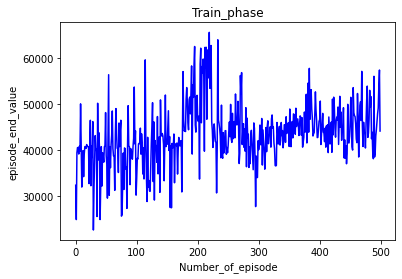

In [ ]:

env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
#action_size = len(env.action_space)
action_size = len(env.action_list)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)

actions_list = []
rewards_list = []
# store the final value of the portfolio (end of episode)
portfolio_value = []
actions_trade = []
trade_action_in_each_ite = []
avg_rawards = []

args = 'train'
# play the game num_episodes times
for e in range(num_episodes):
  t0 = datetime.now()
  val = play_one_episode(agent, env, args)
  dt = datetime.now() - t0
  print(f"episode: {e + 1}/{num_episodes}, episode_end_value: {val[0]:.2f}, duration: {dt}")
  portfolio_value.append(val[0]) # append episode end portfolio value
  actions_list.append(val[1])
  rewards_list.append(val[2])
  actions_trade.append(val[3])
  if num_episodes==499:
    trade_action_in_each_ite.append(val[4])

# save the weights when we are done
if args == 'train':
  # save the DQN
  agent.save(f'{models_folder}/dqn.h5')

  # save the scaler
  with open(f'{models_folder}/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
  # save portfolio value for each episode
  #np.save(f'{rewards_folder}/{args.mode}.npy', portfolio_value)

  #if num_episodes >= 2:
          #avg_rawards.append(np.mean(portfolio_value[-2:]))

plt.plot(portfolio_value, color="Blue")
plt.title("Train_phase")
plt.xlabel("Number_of_episode")
plt.ylabel("episode_end_value")
plt.show()

In [ ]:
#Here I am printing some useful values that I needed for evaluation purpose.
print("############################################################################################################################\n")
print("These outputs are the output of model prediction at the end of each episode\n Actions indexes in action list of below:\n\n ", actions_list)
print("############################################################################################################################\n")
action_list = (env.action_list)
print("\nList of possible actions for 3 stock.\n 0 = sell\n 1 = hold\n 2 = buy \n\n", action_list)
print("############################################################################################################################\n")
print("\nReward at the end of each episode resulted by the model: \n\n", rewards_list)
print("############################################################################################################################\n")
print("\nActions list in 0,1,2 format at the end of each episode resulted by the model\n\n", actions_trade)
print("############################################################################################################################\n")
print("\nWhole actions in 0,1,2 format at each iteration, resulted by the model\n\n", trade_action_in_each_ite)


############################################################################################################################

These outputs are the output of model prediction at the end of each episode
 Actions indexes in action list of below:

  [14, 22, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 14, 14, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 22, 14, 14, 14, 22, 22, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 11, 11, 11, 11, 14, 11, 11, 14, 11, 11, 14, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 20, 11, 20, 11, 11, 11, 11, 20, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 19, 4, 11, 14, 11, 11, 21, 11, 14, 2, 2, 11, 11, 22, 11,

# **Plot the actions trend for each stock through the different episodes**




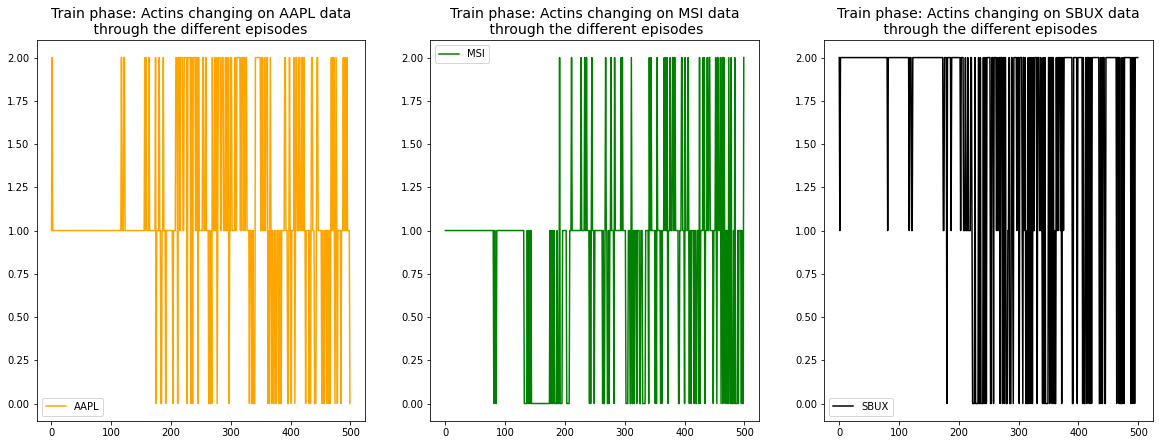

In [ ]:
#Plot the actions for each stocks through the different episodes.
AAPL = []
MSI = []
SBUX = []
for i in (actions_trade):
  for j in i:
    #print(j[0])
    AAPL.append(j[0])
    MSI.append(j[1])
    SBUX.append(j[2])
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (20, 7))
ax1.plot(AAPL, color="orange",)
ax1.set_title("Train phase: Actins changing on AAPL data\n through the different episodes ", fontsize = 14)
ax1.legend(['AAPL'])

ax2.plot(MSI, color="green")
ax2.set_title("Train phase: Actins changing on MSI data\n through the different episodes", fontsize = 14)
ax2.legend(['MSI'])

ax3.plot(SBUX, color="black")
ax3.set_title("Train phase: Actins changing on SBUX data\n through the different episodes", fontsize = 14)
ax3.legend(['SBUX'])

# **Re-training the model for next 500 episodes**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 32)                256       
                                                                 
 dense_3 (Dense)             (None, 27)                891       
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
None
episode: 1/500, episode end value: 47048.55
episode: 2/500, episode end value: 50048.67
episode: 3/500, episode end value: 44444.91
episode: 4/500, episode end value: 49806.12
episode: 5/500, episode end value: 56701.49
episode: 6/500, episode end value: 52945.49
episode: 7/500, episode end value: 59522.78
episode:

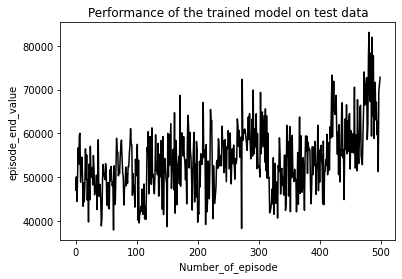

In [ ]:
#Please note that because most of these codes are repeated, So I avoid to commenting them more.
#Reloading and retraining the model for the next 500 episodes
env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)

#some lists for different values 
portfolio_new_value = []
actions_new_list = []
rewards_new_list = []
actions_trade_new = []
with open(f'{models_folder}/scaler.pkl', 'rb') as f:
  scaler = pickle.load(f)
  # remake the env with test data
  env = MultiStockEnv(train_data, initial_investment)

  # make sure epsilon is not 1!
  # no need to run multiple episodes if epsilon = 0, it's deterministic
  agent.epsilon = 0.01
  num_episodes_train = 500
  args = 'train'
  # load trained weights
  agent.load(f'{models_folder}/dqn.h5')
  for e in range(num_episodes_train):
    # play the game num_episodes times
    val_new = play_one_episode(agent, env, args)
    print(f"episode: {e + 1}/{num_episodes_train}, episode end value: {val_new[0]:.2f}")
    portfolio_new_value.append(val_new[0]) # append episode end portfolio value
    actions_new_list.append(val_new[1])
    rewards_new_list.append(val_new[2])
    actions_trade_new.append(val_new[3])
    # save the DQN for 1000 episodes
    agent.save(f'{models_folder}/dqn_1000.h5')

    # save the scaler for 1000 episodes
    with open(f'{models_folder}/scaler_1000.pkl', 'wb') as f:
      pickle.dump(scaler, f)

plt.plot(portfolio_new_value, color="Black")
plt.title("Performance of the trained model on test data")
plt.xlabel("Number_of_episode")
plt.ylabel("episode_end_value")
plt.show()

# **Test the model on test data**

In [ ]:
#Test phase
#Please note that because most of these codes are repeated, So I avoid to commenting them more.
env = MultiStockEnv(train_data, initial_investment)
state_size = env.state_dim
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
def play_one_episode_in_test_phase(agent, env):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info, _trade = env.step(action)
    next_state = scaler.transform([next_state])
    agent.update_replay_memory(state, action, reward, next_state, done)
    agent.replay(batch_size)
    state = next_state
  return info['cur_val'], action, reward, _trade

portfolio_test_value = []
actions_test_list = []
rewards_test_list = []
actions_trade_test = []
with open(f'{models_folder}/scaler_1000.pkl', 'rb') as f:
  scaler = pickle.load(f)

  # remake the env with test data
  env = MultiStockEnv(test_data, initial_investment)

  # make sure epsilon is not 1!
  # no need to run multiple episodes if epsilon = 0, it's deterministic
  agent.epsilon = 0.01
  num_episodes_test = 600
  # load trained weights
  agent.load(f'{models_folder}/dqn_1000.h5')
  for e in range(num_episodes_test):
    # play the game num_episodes times
    val_test = play_one_episode_in_test_phase(agent, env)
    print(f"episode: {e + 1}/{num_episodes_test}, episode end value: {val_test[0]:.2f}")
    portfolio_test_value.append(val_test[0]) # append episode end portfolio value
    actions_test_list.append(val_test[1])
    rewards_test_list.append(val_test[2])
    actions_trade_test.append(val_test[3])



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 27)                891       
                                                                 
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
None
episode: 1/600, episode end value: 22443.18
episode: 2/600, episode end value: 27802.63
episode: 3/600, episode end value: 28393.38
episode: 4/600, episode end value: 20171.77
episode: 5/600, episode end value: 28760.53
episode: 6/600, episode end value: 27360.58
episode: 7/600, episode end value: 27661.41
episode: 8

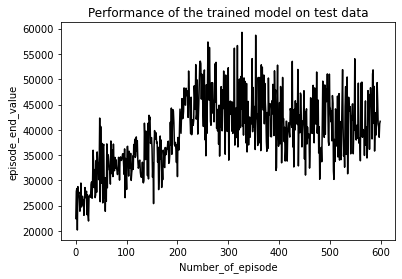

In [ ]:
#Point: I don't know why I faced with error at the end of 600 episodes to plot. But there is no problem. 
#Because It is taking 11 hours to run again just to plot. So, I plot it here correctly 
plt.plot(portfolio_test_value, color="Black")
plt.title("Performance of the trained model on test data")
plt.xlabel("Number_of_episode")
plt.ylabel("episode_end_value")
plt.show()

In [ ]:
#printing some useful values for us to evaluating our model in test phase.
print("############################################################################################################################\n")
print("These outputs are the output of model prediction at the end of each episode\n Actions indexes in action list of below:\n\n ", actions_test_list)
print("############################################################################################################################\n")
action_list = (env.action_list)
print("\nList of possible actions for 3 stock.\n 0 = sell\n 1 = hold\n 2 = buy \n\n", action_list)
print("############################################################################################################################\n")
print("\nReward at the end of each episode resulted by the model: \n\n", rewards_test_list)
print("############################################################################################################################\n")
print("\nActions list in 0,1,2 format at the end of each episode resulted by the model\n\n", actions_trade_test)
print("############################################################################################################################\n")

############################################################################################################################

These outputs are the output of model prediction at the end of each episode
 Actions indexes in action list of below:

  [19, 19, 19, 19, 19, 4, 4, 4, 19, 4, 19, 4, 1, 4, 1, 4, 19, 4, 19, 11, 19, 11, 19, 4, 15, 12, 12, 12, 9, 12, 15, 2, 18, 9, 15, 19, 22, 22, 22, 18, 12, 2, 19, 18, 9, 10, 19, 16, 19, 19, 19, 23, 19, 8, 18, 18, 18, 16, 18, 18, 18, 18, 4, 18, 18, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 18, 18, 18, 18, 18, 18, 15, 15, 15, 18, 16, 15, 19, 19, 15, 15, 15, 19, 24, 22, 22, 22, 22, 15, 24, 15, 15, 15, 23, 23, 23, 23, 23, 19, 19, 23, 23, 19, 23, 19, 22, 19, 22, 19, 23, 19, 25, 19, 25, 22, 22, 19, 26, 22, 26, 19, 25, 25, 25, 13, 13, 13, 25, 13, 13, 13, 25, 18, 13, 16, 25, 18, 25, 25, 18, 25, 16, 16, 13, 16, 25, 25, 26, 26, 26, 25, 25, 25, 25, 18, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 18, 25, 25, 25, 25, 25

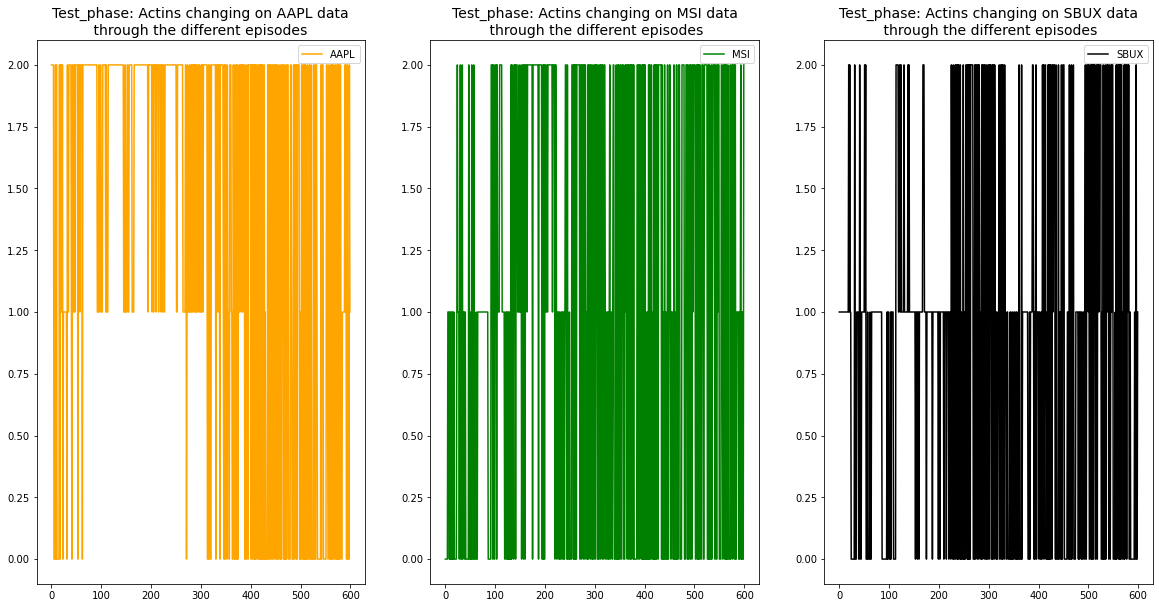

In [ ]:
#Plot the actions for each stacks through the different episodes in test phase.
AAPL = []
MSI = []
SBUX = []
#These list are just including sell and buy actions, not including hold action. just to have good and sensible plot for output.
AAPL2 = []
MSI2 = []
SBUX2 = []
for i in (actions_trade_test):
  for j in i:
    #print(j[0])
    AAPL.append(j[0])
    MSI.append(j[1])
    SBUX.append(j[2])
for k1 in MSI:
  if k1!=0:
    AAPL2.append(k1)
for k2 in AAPL:
  if k2!=0:
    MSI2.append(k2)
for k3 in SBUX:
  if k3!=0:
    SBUX2.append(k3)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (20, 10))
ax1.plot(AAPL, color="orange")
ax1.set_title("Test_phase: Actins changing on AAPL data\n through the different episodes ", fontsize = 14)
ax1.legend(['AAPL'])

ax2.plot(MSI, color="green")
ax2.set_title("Test_phase: Actins changing on MSI data\n through the different episodes", fontsize = 14)
ax2.legend(['MSI'])

ax3.plot(SBUX, color="black")
ax3.set_title("Test_phase: Actins changing on SBUX data\n through the different episodes", fontsize = 14)
ax3.legend(['SBUX'])

In [ ]:
    #I converted List to array to use in our plot at the below cell
    print(AAPL)
    actions_over_time1 = np.array(AAPL)
    actions_over_time2 = np.array(MSI)
    actions_over_time3 = np.array(SBUX)
    print(actions_over_time1)

[2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 

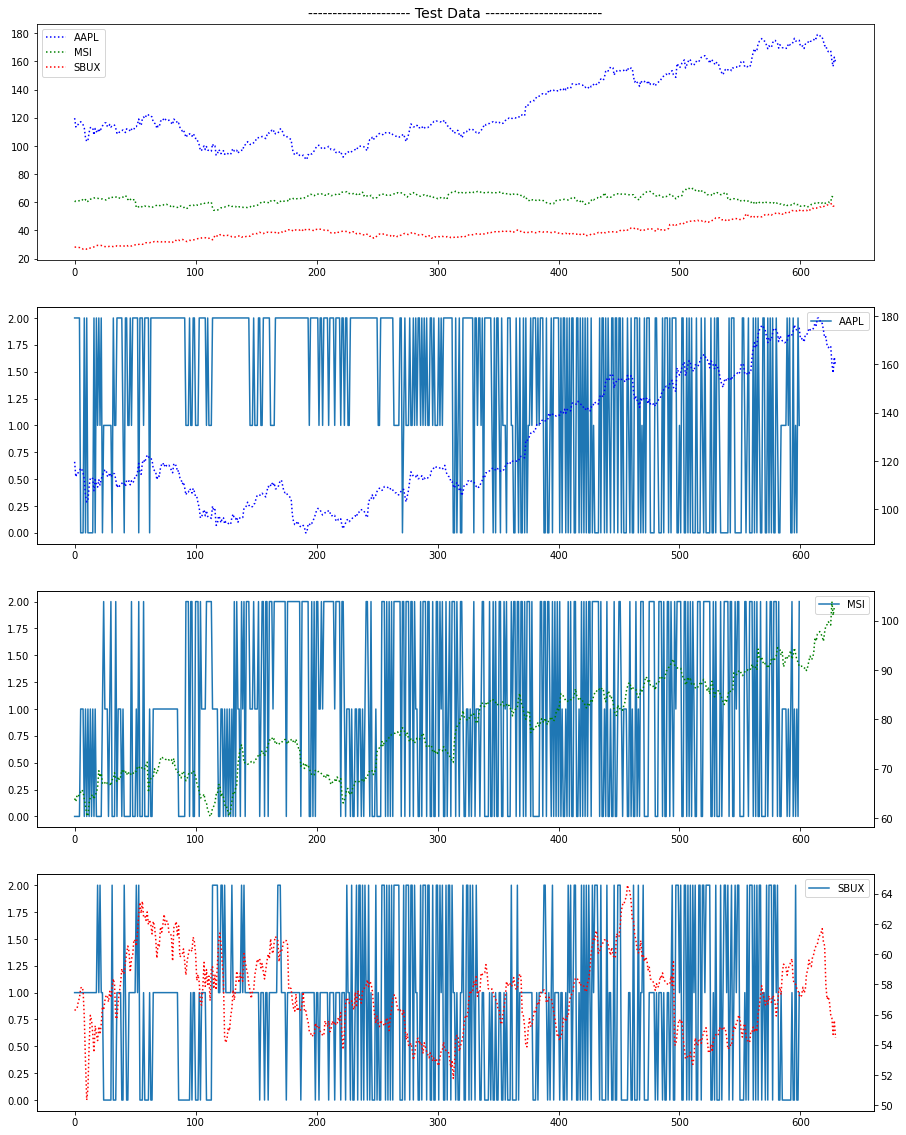

In [ ]:
#Plot the test data (separately for each stock) along side the action in each step of our data to increase the portfolio value.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20))
ax1.plot(test_data[:,0], color="blue", ls = 'dotted')
ax1.plot(train_data[:,1], color="green", ls = 'dotted')
ax1.plot(train_data[:,2], color="red", ls = 'dotted')
ax1.set_title("--------------------- Test Data ------------------------", fontsize = 14)
ax1.legend(['AAPL', 'MSI', 'SBUX'])


ax2.plot(actions_over_time1.flatten(), label = 'Actions')
ax2_copy = ax2.twinx()
ax2_copy.plot(test_data[:,0], label = 'RSI', color = 'blue', ls = 'dotted')
ax2.legend(['AAPL'])


ax3.plot(actions_over_time2.flatten(), label = 'Actions')
ax3_copy = ax3.twinx()
ax3_copy.plot(test_data[:,1], label = 'RSI', color = 'green', ls = 'dotted')
ax3.legend(['MSI'])

ax4.plot(actions_over_time3.flatten(), label = 'Actions')
ax4_copy = ax4.twinx()
ax4_copy.plot(test_data[:,2], label = 'RSI', color = 'red', ls = 'dotted')
ax4.legend(['SBUX'])
plt.show()